This notebook logs the preparation of the bcs sentiment analysis datases. 

# Preliminary exploration and corrections

* Dataset is based on the file `"bcs_polsent_20220502.xlsx"`, sent to peter.rupnik@ijs.si 2022-05-02T22:50+02:00.
* As agreed in a Skype meeting only the first sheet will be used for dev and test and labels will be downcast to 3 (positive, negative, neutral).



In [34]:
import pandas as pd

df = pd.read_excel("bcs_polsent_20220502.xlsx", "1-1300", index_col="id")
df2 = pd.read_excel("bcs_polsent_20220502.xlsx", "1301-2600", index_col="id")
df2 = df2.rename(columns={
    "text": "sentence"
})
df.head(2)

,sentence,country,type,annotator1,annotator2,gold,reconciliation_hard,id_meta,term,doc_id,sentence_id,date,fullname,party,gender,yob,edu_y,ideology,no_seats,ruling
id,,,,,,,,,,,,,,,,,,,,
1,Ja shvatam da međunarodna zajednica i oni koji...,BiH,pilot,Negative,M_Negative,soft_disagreement,0,15262,0,3055,4,19991110,"Špirić, Nikola",SDS,0.0,1956.0,22,NaN,4.0,1.0
2,"Npr. mene i moje braće, npr. mi tražimo našu i...",BiH,pilot,Negative,Negative,Negative,0,72709,0,13704,8,20020417,"Kulenović, Salih",SDA,0.0,1944.0,16,NaN,8.0,0.0


In [35]:
df2.head(3)

,sentence,country,type,annotator2,id_meta,term,doc_id,sentence_id,date,fullname,party,gender,yob,edu_y,ideology,no_seats,ruling
id,,,,,,,,,,,,,,,,,
1301,"Dakle, od Australije do Belgije, Nizozemske gd...",HR,full2,P_Neutral,2671946,7,74214,3,20140313,"Grubišić, Boro",HDSSB,0.0,1952.0,22,NaN,6.0,0.0
1302,"Dame i gospodo narodni poslanici, još jednom ž...",SRB,full2,P_Neutral,7486612,11,69962,2,20200129,"Bojić, Dubravko",SRS,0.0,1953.0,22,NaN,22.0,0.0
1303,"Nažalost, policijski lobi je stalno prisutan, ...",SRB,full2,Negative,4814977,5,27992,15,20030409,"Krasić, Zoran",SRS,0.0,1956.0,18,NaN,23.0,0.0


Prepare a column `label` that we will use:

In [36]:
df["label"] = df.gold
df2["label"] = df.annotator2 # As we do not have gold in the second sheet.

Overwrite `label` with `reconciliation_hard`, where the latter is non-trivial (i.e. non-zero):

In [37]:
condition_reconciliation_not_zero = df.reconciliation_hard != 0
df.loc[condition_reconciliation_not_zero, "label"] = df.reconciliation_hard[condition_reconciliation_not_zero]

df.label.value_counts()

Negative             539
P_Neutral            218
Positive             184
soft_disagreement    175
N_Neutral             80
M_Negative            60
M_Positive            44
Name: label, dtype: int64

Note the presence of 175 instances of soft disagreement. Let us check this out:

In [38]:
df[df.label=="soft_disagreement"].head(3)

,sentence,country,type,annotator1,annotator2,gold,reconciliation_hard,id_meta,term,doc_id,...,date,fullname,party,gender,yob,edu_y,ideology,no_seats,ruling,label
id,,,,,,,,,,,,,,,,,,,,,
1,Ja shvatam da međunarodna zajednica i oni koji...,BiH,pilot,Negative,M_Negative,soft_disagreement,0,15262,0,3055,...,19991110,"Špirić, Nikola",SDS,0.0,1956.0,22,NaN,4.0,1.0,soft_disagreement
14,Ponekad u potrebi da se rješava mnogo stvari p...,BiH,pilot,Negative,M_Negative,soft_disagreement,0,534181,0,114977,...,20160627,"Škaljić, Fehim",SBB,0.0,1949.0,12,NaN,4.0,1.0,soft_disagreement
16,Da li Vijeće ministara raspolaže sa analizom k...,BiH,pilot,N_Neutral,P_Neutral,soft_disagreement,0,555612,0,120407,...,20170726,"Mehmedović, Šemsudin",SDA,0.0,1961.0,18,NaN,10.0,1.0,soft_disagreement


We might resolve this with downcasting labels to but three. Let us do this now.

In [39]:
labels = df.label.unique()
labels

array(['soft_disagreement', 'Negative', 'Positive', 'M_Negative',
       'N_Neutral', 'P_Neutral', 'M_Positive'], dtype=object)

In [40]:
def correct_label(l: str) -> str:
    """Downcasts label from the original labelset
    to only {Positive,Negative,Neutral}. If unable
    to downcast, returns input string.

    Args:
        l (str): input string label.

    Returns:
        str: downcast label
    """    
    downcast_dict = {
        'Negative': "Negative",
        'Positive': "Positive",
        'M_Negative': "Negative",
        'N_Neutral': "Neutral", 
        'P_Neutral': "Neutral", 
        'M_Positive': "Positive",
                   }
    return downcast_dict.get(l, l)

df["annotator1_downcast"] = df.annotator1.apply(correct_label)
df["annotator2_downcast"] = df.annotator2.apply(correct_label)

df["label"] = df.label.apply(correct_label)

# For the second sheet the task is easier:

df2["label"] = df2.annotator2.apply(correct_label)
# Inspect the composition of df2:
df2.label.value_counts()


Negative    692
Neutral     410
Positive    198
Name: label, dtype: int64

In [41]:
condition_label_is_soft_disagreement = df.label == "soft_disagreement"
condition_downcast_annotations_differ = df.annotator1_downcast != df.annotator2_downcast

sum(condition_downcast_annotations_differ & condition_label_is_soft_disagreement)

0

As suspected, if we downcast the labels from annotators, the disagreement is resolved. We can now overwrite the labels `soft_disagreement`:

In [42]:
df.loc[condition_label_is_soft_disagreement, "label"] = df.loc[
    condition_label_is_soft_disagreement, "annotator1_downcast"
]

df.label.value_counts()


Negative    666
Neutral     362
Positive    272
Name: label, dtype: int64

The auxiliary columns can be dropped:

In [43]:
df.drop(
    columns=[
        "annotator1_downcast",
        "annotator2_downcast",
    ],
    inplace=True,
)


# Splitting

A train-dev-test split shall be performed and split composition shall be evaluated graphically. Split is to be stratified on `country`. But let us first join the two sheets.

In [44]:
set(df.columns).difference(df2.columns)

{'annotator1', 'gold', 'reconciliation_hard'}

In [45]:
set(df2.columns).difference(df.columns)

set()

In [50]:
df["origin"] = "1-1300"
df2["origin"] = "1301-2600"

With the code below I briefly searched for the 'best' random seeds that would minimize standard deviations of the party splits. These seeds will be used for splitting.

In [147]:
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.auto import tqdm
splits = ["train", "test", "dev"]
min_stat = 1e8
best_i = 0
best_j = 0
for i in tqdm(range(200)):
    for j in range(200):
        dev, rest = train_test_split(df, train_size=150, stratify=df.country, random_state=i)
        test, rest = train_test_split(rest, train_size=300, stratify=rest.country, random_state=j)
        train = pd.concat([rest, df2])
        stat = pd.DataFrame(data={
            split:eval(split).party.value_counts(normalize=True) for split in splits
            }).fillna(value=0).apply(np.std, axis=1).sum()
        if stat < min_stat:
            best_i, best_j = i, j
            min_stat = stat


  0%|          | 0/200 [00:00<?, ?it/s]

In [148]:
best_i, best_j, stat

(97, 71, 0.2520323627542212)

Perform the splits with the supposedly-optimal seeds:

In [149]:
dev, rest = train_test_split(df, train_size=150, stratify=df.country, random_state=best_i)
test, rest = train_test_split(rest, train_size=300, stratify=rest.country, random_state=best_j)
train = pd.concat([rest, df2])

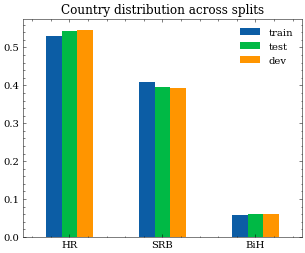

In [150]:
import matplotlib.pyplot as plt
try:
    plt.style.use("science no-latex".split())
except:
    pass
splits = ["train", "test", "dev"]

fig, ax = plt.subplots(figsize=(5,4))
pd.DataFrame(data={
    split:eval(split).country.value_counts(normalize=True) for split in splits
    }).plot.bar(ax=ax, rot=0)
plt.title("Country distribution across splits")
plt.savefig("images/001_country_distribution_across_splits.png")
plt.show()



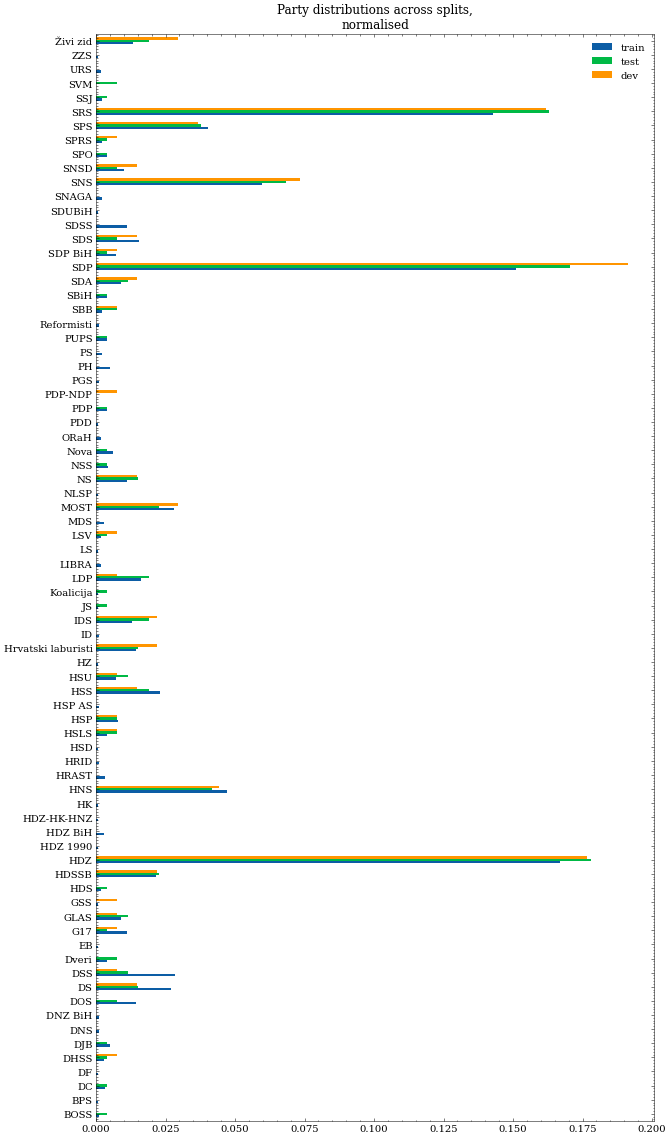

In [151]:
fig, ax = plt.subplots(figsize=(10, 20))
pd.DataFrame(data={
    split:eval(split).party.value_counts(normalize=True) for split in splits
    }).plot.barh(ax=ax, rot=0)
plt.savefig("images/001_party_distribution_across_splits.png")
plt.title("Party distributions across splits,\nnormalised")
plt.show()

Even with the brute force optimization the distributions do not seem much better. Mostly the difference is in the smaller variance in the most populous parties (notably HDZ), where the phase space is big and a lot of improvements can be made.

Let us now reconstruct the dataset from the thus created splits and perform one last inspection.

In [158]:
splits = ["train", "test", "dev"]
for split in splits:
    eval(split)["split"] = split

df_out = pd.concat([eval(split) for split in splits]).sort_index()
df_out.head()

,sentence,country,type,annotator1,annotator2,gold,reconciliation_hard,id_meta,term,doc_id,...,party,gender,yob,edu_y,ideology,no_seats,ruling,label,origin,split
id,,,,,,,,,,,,,,,,,,,,,
1,Ja shvatam da međunarodna zajednica i oni koji...,BiH,pilot,Negative,M_Negative,soft_disagreement,0,15262,0,3055,...,SDS,0.0,1956.0,22,NaN,4.0,1.0,Negative,1-1300,train
2,"Npr. mene i moje braće, npr. mi tražimo našu i...",BiH,pilot,Negative,Negative,Negative,0,72709,0,13704,...,SDA,0.0,1944.0,16,NaN,8.0,0.0,Negative,1-1300,test
3,"Pa normalno da nije, ali vidite, pustite kad m...",BiH,pilot,Negative,Negative,Negative,0,113526,0,22174,...,SDP BiH,0.0,1955.0,16,NaN,4.0,0.0,Negative,1-1300,dev
4,"Pomoći ovim ljudima, da danas ti ljudi mogu i ...",BiH,pilot,Negative,Negative,Negative,0,144839,0,28022,...,SPRS,0.0,1955.0,22,NaN,1.0,0.0,Negative,1-1300,train
5,"Dakle, uz puno uvažavanje, ovo što zna element...",BiH,pilot,Negative,Negative,Negative,0,174523,0,34063,...,SDP BiH,0.0,1955.0,16,NaN,4.0,0.0,Negative,1-1300,train


In [159]:
df_out.tail()

,sentence,country,type,annotator1,annotator2,gold,reconciliation_hard,id_meta,term,doc_id,...,party,gender,yob,edu_y,ideology,no_seats,ruling,label,origin,split
id,,,,,,,,,,,,,,,,,,,,,
2596,"Ali, reći za jednu poslaničku grupu da je plju...",SRB,full2,NaN,Negative,NaN,NaN,7295439,11,53038,...,SRS,1.0,1955.0,18,NaN,22.0,0.0,Negative,1301-2600,train
2597,Ići na 25% čime ćemo se tek približiti ili doć...,HR,full2,NaN,N_Neutral,NaN,NaN,2076914,7,877,...,HNS,0.0,1956.0,18,NaN,14.0,1.0,Neutral,1301-2600,train
2598,Broj zaposlenih u odnosu na 90-te i danas vari...,HR,full2,NaN,P_Neutral,NaN,NaN,1890314,6,58127,...,Hrvatski laburisti,NaN,NaN,NaN,NaN,1.0,0.0,Neutral,1301-2600,train
2599,Bit će tu sasvim sigurno lista grupe građana i...,HR,full2,NaN,P_Neutral,NaN,NaN,2953665,7,109311,...,HDSSB,0.0,1952.0,22,NaN,6.0,0.0,Neutral,1301-2600,train
2600,"Jedan i drugi su neprihvatljivi su za SRS, po ...",SRB,full2,NaN,Negative,NaN,NaN,6183701,8,62467,...,SRS,0.0,1957.0,16,NaN,78.0,0.0,Negative,1301-2600,train


Finally we can assign party orientation with the mapping, conveyed in the Skype message from Nikola, 20220503T0919+02:00

In [161]:
HR_party_orientation = {
'SDP':'center-left',
'HDZ':'center-right',
'Most':'right',
'Nezavisni':None,
'HSU, SNAGA, NZ i NP':'center-left',
'SDSS':'center-left',
'HNS':'center-left',
'BM 365 i NZ':'center-left',
'Živi zid, SNAGA':None,
'HSS i Demokrati':'center-right',
'GLAS':'center-left',
'HDS, HSLS, HDSSB':'center-right',
'NLM':'center-right',
'Živi zid i PH':None,
'IDS, PGS, RI':'center-left',
'HS':'right',
# Added by Peter:
'HSU': 'center-left', 
'SNAGA': 'center-left', 
'NZ': 'center-left',
'NP':'center-left',
'BM 365': 'center-left',
'NZ':'center-left',
'Živi zid': None,
'SNAGA': None,
'HSS': 'center-right',
'Demokrati':'center-right',
'HDS': 'center-right', 
'HSLS': 'center-right', 
'HDSSB':'center-right',
'PH':None,
'IDS': 'center-left',
'PGS': 'center-left',
'RI':'center-left',
}
HR_party_orientation = {key.lower(): value for key, value in HR_party_orientation.items()}
df_out["party_orientation"] = None
df_out.loc[~df_out.party.isna(),"party_orientation"] = df_out.party[~df_out.party.isna()].apply(lambda s: HR_party_orientation.get(s.lower(), None))

In [162]:
df_out.tail()

,sentence,country,type,annotator1,annotator2,gold,reconciliation_hard,id_meta,term,doc_id,...,gender,yob,edu_y,ideology,no_seats,ruling,label,origin,split,party_orientation
id,,,,,,,,,,,,,,,,,,,,,
2596,"Ali, reći za jednu poslaničku grupu da je plju...",SRB,full2,NaN,Negative,NaN,NaN,7295439,11,53038,...,1.0,1955.0,18,NaN,22.0,0.0,Negative,1301-2600,train,None
2597,Ići na 25% čime ćemo se tek približiti ili doć...,HR,full2,NaN,N_Neutral,NaN,NaN,2076914,7,877,...,0.0,1956.0,18,NaN,14.0,1.0,Neutral,1301-2600,train,center-left
2598,Broj zaposlenih u odnosu na 90-te i danas vari...,HR,full2,NaN,P_Neutral,NaN,NaN,1890314,6,58127,...,NaN,NaN,NaN,NaN,1.0,0.0,Neutral,1301-2600,train,None
2599,Bit će tu sasvim sigurno lista grupe građana i...,HR,full2,NaN,P_Neutral,NaN,NaN,2953665,7,109311,...,0.0,1952.0,22,NaN,6.0,0.0,Neutral,1301-2600,train,center-right
2600,"Jedan i drugi su neprihvatljivi su za SRS, po ...",SRB,full2,NaN,Negative,NaN,NaN,6183701,8,62467,...,0.0,1957.0,16,NaN,78.0,0.0,Negative,1301-2600,train,None


In [163]:
df_out.party_orientation.isna().sum()

1493

We have 1493/2600 instances where the party orientation assignment failed. But this is to be expected, given that we only cover croatian parties and even those have a lot of NAs.

Finally we save the dataset in jsonl format.

In [164]:
df_out.to_json("bcm_polsent.jsonl", orient="records", lines=True)